In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from timeit import default_timer as timer 
from torch.utils.data import Dataset, DataLoader

In [18]:
# Setup hyperparameters
BATCH_SIZE = 32 # good for your health: https://twitter.com/ylecun/status/989610208497360896
IMAGE_SIZE = (224, 224) # (height, width) smaller images means faster computing 
NUM_EPOCHS = 3 # only run for a short period of time... we don't have all day
DATASET_NAME = "cifar10" # dataset to use (there are more in torchvision.datasets)
MACHINE = "Apple M2 Pro" # change this depending on where you're runing the code
NUM_WORKERS = 2 # set number of cores to load data

In [3]:


def print_train_time(start, end, device=None, machine=None):
    """Prints difference between start and end time.
    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    if device:  
        print(f"\nTrain time on {machine} using PyTorch device {device}: {total_time:.3f} seconds\n")
    else:
        print(f"\nTrain time: {total_time:.3f} seconds\n")
    return round(total_time, 3)

In [4]:
simple_transform = transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE),
    transforms.ToTensor()
])

# Get Datasets
train_data = datasets.CIFAR10(root="data",
                              train=True,
                              transform=simple_transform,
                              download=True)

test_data = datasets.CIFAR10(root="data",
                             train=False,
                             transform=simple_transform,
                             download=True)

print(f"Number of training samples: {len(train_data)}, number of testing samples: {len(test_data)}")

# Create DataLoaders
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS,
                             pin_memory=True)

train_dataloader, test_dataloader
train_data[0][0].shape

Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 50000, number of testing samples: 10000


torch.Size([3, 224, 224])

In [5]:
# Get class names
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
# take in a Dataset as well as the class names
import random
from typing import List
import matplotlib.pyplot as plt

def show_random_images(dataset: Dataset, class_names: List[str]=None, n: int=10, display_shape: bool = True, seed: int= None):
    # adjust display if n too high
    if n > 10:
        n = 10
        print("n too high, setting to 10")
    
    # set seed if provided
    if seed:
        random.seed(seed)

    # Get random samples indexes
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    # setup plot
    plt.figure(figsize=(16, 8))

    # loop through random sample indexes and plot
    for i, target_idx in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[target_idx][0], dataset[target_idx][1]

        # Adjust image tensor shape for plotting: [color_channels, height, width] -> [height, width, color_channels]
        targ_image = targ_image.permute(1, 2, 0)

        # plot image
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image)
        plt.xticks([])
        plt.yticks([])
        if class_names:
            title = f"class: {class_names[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image.shape}"
        plt.title(title)

    plt.show()

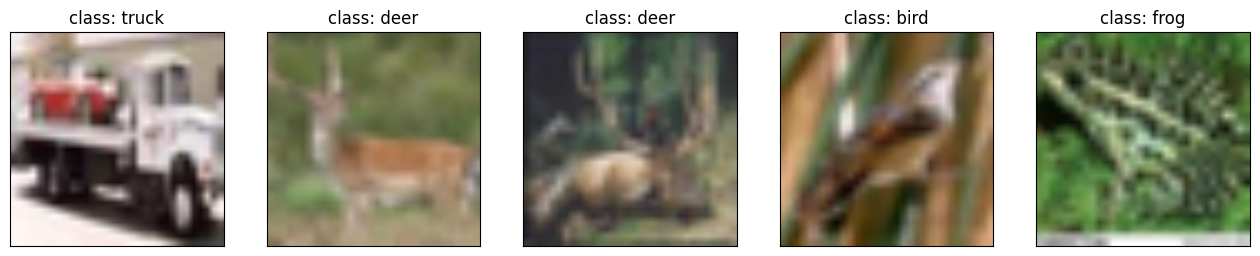

In [7]:
# Show 10 random images from training data
show_random_images(train_data, class_names, n=5, display_shape=False, seed=42)

In [8]:
class TinyVGG(nn.Module):
    """Create the TinyVGG architecture.
    
    Args:
        input_shape (tuple): Shape of the input data (image), usually (batch, height, width, channels).
        hidden_units (int): Number of hidden units in the first and second Dense layers.
        output_shape (int): Number of outputs to produce.
    """
    def __init__(self, input_shape=(3, 224, 224), hidden_units=256, output_shape=10) -> None:
        super(TinyVGG, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*53*53, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
    



    

In [9]:
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=10)

model(torch.randn(1, 3, 224, 224))

tensor([[-0.0873, -0.0186, -0.0140, -0.0027, -0.0101,  0.1332, -0.0040,  0.0256,
         -0.0061, -0.0360]], grad_fn=<AddmmBackward0>)

In [10]:
torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

device(type='mps')

### Setup training/testing

In [11]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> float:
    
    # put model in train mode
    model.train()

    # setup loss and accuracy
    train_loss, train_acc = 0.0, 0.0

    # loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to device
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

        # forward pass
        y_pred = model(X)

        # calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()

        # calculate accuracy
        y_pred_class  = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += torch.sum(y_pred_class == y).item() / len(y)

    # return loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)

In [12]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> float:
    
    # put model in eval mode
    model.eval()

    # setup loss and accuracy
    test_loss, test_acc = 0.0, 0.0

    # loop through data loader batches
    with torch.inference_mode():
        # loop through data loader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to device
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

            # forward pass
            test_pred_logits = model(X)

            # calculate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # calculate accuracy
            test_pred_class  = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += torch.sum(test_pred_class == y).item() / len(y)

    # return loss and accuracy
    return test_loss / len(dataloader), test_acc / len(dataloader)

In [13]:
from tqdm.auto import tqdm

/Users/elotech/.virtualenvs/mlEnv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader,
            test_dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer, device: torch.device, num_epochs: int) -> None:
    """Trains a PyTorch model.
    Args:
        model (torch.nn.Module): PyTorch model to train.
        train_dataloader (torch._utils.data.DataLoader): Training data.
        test_dataloader (torch._utils.data.DataLoader): Testing data.
        loss_fn (torch.nn.Module): Loss function to use.
        optimizer (torch.optim.Optimizer): Optimizer to use.
        device (torch.device): Device to use.
        num_epochs (int): Number of epochs to train for.
    """
    print(f"[INFO] Training model {model.__class__.__name__} for {num_epochs} epochs on {device}...")

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(num_epochs)):
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(f"[INFO] Epoch {epoch+1}/{num_epochs}: train_loss: {train_loss:.4f} - train_acc: {train_acc:.4f} - test_loss: {test_loss:.4f} - test_acc: {test_acc:.4f}")

    return results


### TRAIN the Model on CPU and MPS Device (GPU)


[INFO] Training model TinyVGG for 3 epochs on mps...


  0%|          | 0/3 [00:00<?, ?it/s]/Users/elotech/.virtualenvs/mlEnv/lib/python3.11/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():
 33%|███▎      | 1/3 [01:21<02:43, 81.58s/it]

[INFO] Epoch 1/3: train_loss: 1.8549 - train_acc: 0.3352 - test_loss: 2.3037 - test_acc: 0.0998


 67%|██████▋   | 2/3 [02:39<01:19, 79.13s/it]

[INFO] Epoch 2/3: train_loss: 1.6446 - train_acc: 0.4207 - test_loss: 1.7090 - test_acc: 0.3992


100%|██████████| 3/3 [03:56<00:00, 78.77s/it]

[INFO] Epoch 3/3: train_loss: 1.5813 - train_acc: 0.4428 - test_loss: 1.5843 - test_acc: 0.4372

Train time on Apple M2 Pro using PyTorch device mps: 236.296 seconds



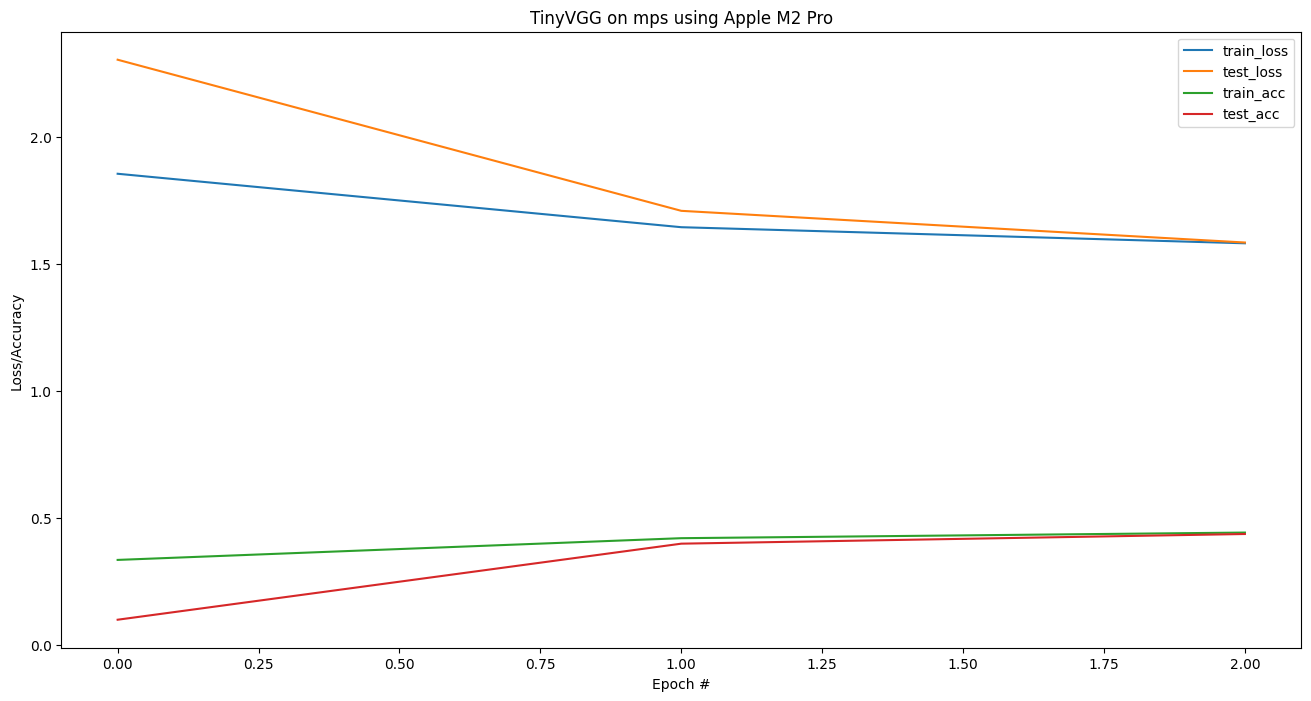

In [19]:
# set random seed
torch.manual_seed(42)

#create device variable to hold cpu or mps

devices = ['mps', 'cpu']

for device in devices:
    

    # recreate an instance of the TinyVGG model
    model = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)
    # setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # start timer
    from timeit import default_timer as timer
    start = timer()

    # train model
    model_results = train(model, train_dataloader, test_dataloader, loss_fn, optimizer, device, num_epochs=NUM_EPOCHS)

    # end timer
    end = timer()

    # print train time
    print_train_time(start, end, device=device, machine=MACHINE)

    # create result dict
    results = {
        "model": model.__class__.__name__,
        "machine": MACHINE,
        "device": device,
        'dataset_name' : DATASET_NAME,
        "batch_size": BATCH_SIZE,
        "image_size": IMAGE_SIZE,
        "num_epochs": NUM_EPOCHS,
        "num_train_samples": len(train_data),
        "num_test_samples": len(test_data),
        "train_time": round(end - start, 3),
        "time per epoch": round((end - start) / NUM_EPOCHS, 3),
        "train_loss": model_results["train_loss"],
        "train_acc": model_results["train_acc"],
        "test_loss": model_results["test_loss"],
        "test_acc": model_results["test_acc"]
    }

    # save results
    import json
    with open(f"results/{model.__class__.__name__}_{device}.json", "w") as f:
        json.dump(results, f)

# plot results
plt.figure(figsize=(16, 8))
plt.plot(model_results["train_loss"], label="train_loss")
plt.plot(model_results["test_loss"], label="test_loss")
plt.plot(model_results["train_acc"], label="train_acc")
plt.plot(model_results["test_acc"], label="test_acc")
plt.title(f"{model.__class__.__name__} on {device} using {MACHINE}")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


In [20]:
# load results
import json
cpu_results = json.load(open("results/TinyVGG_cpu.json"))
mps_results = json.load(open("results/TinyVGG_mps.json"))

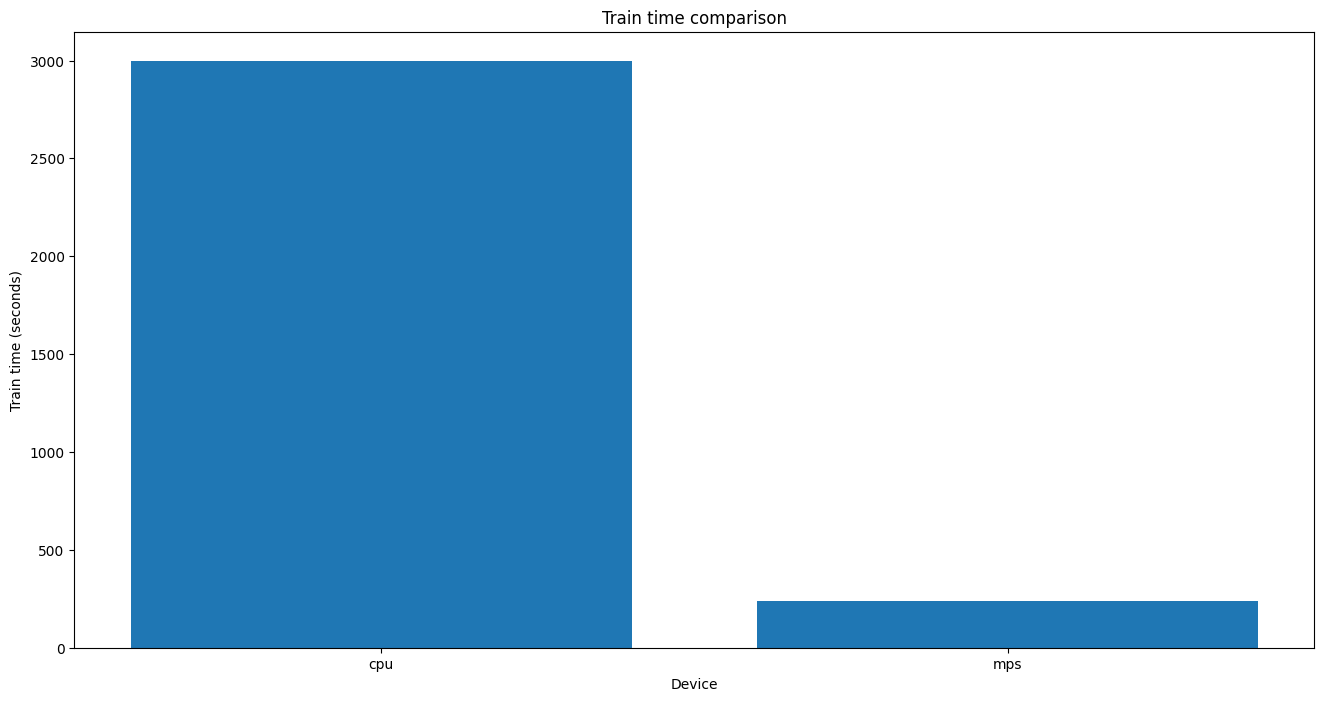

In [21]:
# compare run times on cpu vs mps
plt.figure(figsize=(16, 8))
plt.bar(x=["cpu", "mps"], height=[cpu_results["train_time"], mps_results["train_time"]])
plt.title("Train time comparison")
plt.xlabel("Device")
plt.ylabel("Train time (seconds)")
plt.show()